In [1]:
import pandas as pd
# Load files
errors_df = pd.read_csv(r'D:\Desktop\MS ML Intern\Azure Maintenance\Azure Maintenance\PdM_errors.csv')
failures_df = pd.read_csv(r'D:\Desktop\MS ML Intern\Azure Maintenance\Azure Maintenance\PdM_failures.csv')
machines_df = pd.read_csv(r'D:\Desktop\MS ML Intern\Azure Maintenance\Azure Maintenance\PdM_machines.csv')
maint_df = pd.read_csv(r'D:\Desktop\MS ML Intern\Azure Maintenance\Azure Maintenance\PdM_maint.csv')
telemetry_df = pd.read_csv(r'D:\Desktop\MS ML Intern\Azure Maintenance\Azure Maintenance\PdM_telemetry.csv')

In [2]:
#Convert datetime columns to datetime objects
telemetry_df['datetime'] = pd.to_datetime(telemetry_df['datetime'])
errors_df['datetime'] = pd.to_datetime(errors_df['datetime'])
failures_df['datetime'] = pd.to_datetime(failures_df['datetime'])
maint_df['datetime'] = pd.to_datetime(maint_df['datetime'])

滚动窗口提取机器数据的时间特征(24H均值)

In [77]:
df = telemetry_df

# 保留原始的 datetime 列以备后用
original_datetime = df['datetime']
original_machineID = df['machineID']

# 从 DataFrame 中移除 datetime 列
df_numeric = df.drop(columns=['datetime'])

# 对于每24行数据计算均值
rolling_df = df_numeric.rolling(window=24, min_periods=1, closed='both').mean()

# # 计算滚动窗口的最大值
# rolling_max = df_numeric.rolling(window=24, min_periods=1, closed='both').max()
# rolling_max['datetime'] = original_datetime
# rolling_max['machineID'] = original_machineID


# # 计算滚动窗口的最小值
# rolling_min = df_numeric.rolling(window=24, min_periods=1, closed='both').min()
# rolling_min['datetime'] = original_datetime
# rolling_min['machineID'] = original_machineID


# 计算滚动窗口的标准差
# rolling_std = df_numeric.rolling(window=24, min_periods=1, closed='both').std()
# rolling_std['datetime'] = original_datetime
# rolling_std['machineID'] = original_machineID

# 将原始的 datetime 列添加回去
rolling_df['datetime'] = original_datetime
rolling_df['machineID'] = original_machineID

# # 将计算出的统计数据合并到 rolling_means 中
# rolling_df = rolling_df.merge(rolling_max, on=['datetime', 'machineID'], suffixes=('', '_max'))
# rolling_df = rolling_df.merge(rolling_min, on=['datetime', 'machineID'], suffixes=('', '_min'))
# rolling_df = rolling_df.merge(rolling_std, on=['datetime', 'machineID'], suffixes=('', '_std'))


In [75]:
rolling_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   machineID  876100 non-null  int64         
 1   volt       876100 non-null  float64       
 2   rotate     876100 non-null  float64       
 3   pressure   876100 non-null  float64       
 4   vibration  876100 non-null  float64       
 5   datetime   876100 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 40.1 MB


### 维护每个组件自上次维护以来的时间

In [78]:
# 合并rolling_means和maint数据
combined_df = pd.merge(rolling_df, maint_df, on=['datetime', 'machineID'], how='outer')
# 排序
combined_df.sort_values(by=['machineID', 'datetime'], inplace=True)

In [79]:
# 初始化维护时间列
def maint_comp(combined_df):
    for comp in ['comp1', 'comp2', 'comp3', 'comp4']:
        combined_df[f'time_since_last_{comp}'] = 0
    
    # 初始化上次维护时间的字典
    last_maint_time = {comp: {machine: None for machine in combined_df['machineID'].unique()} for comp in ['comp1', 'comp2', 'comp3', 'comp4']}
    
    # 遍历合并后的记录
    for index, row in combined_df.iterrows():
        machine_id = row['machineID']
        current_time = row['datetime']
        current_comp = row['comp']
    
        # 更新所有组件的维护时间
        for comp in ['comp1', 'comp2', 'comp3', 'comp4']:
            # 如果存在上次维护时间，则计算时间差
            if last_maint_time[comp].get(machine_id):
                time_diff = (current_time - last_maint_time[comp][machine_id]).total_seconds() / (3600*24)  
                combined_df.at[index, f'time_since_last_{comp}'] = time_diff
    
            # 对当前维护的组件更新上次维护时间
            if comp == current_comp:
                last_maint_time[comp][machine_id] = current_time
    
    # 剔除maint_df中2014年及更早的数据
    combined_df = combined_df[combined_df['datetime'] >= '2015-01-01']

    # 筛选出 datetime 中时间为早上6点的行
    # combined_df = combined_df[combined_df['datetime'].dt.hour == 6]

    return combined_df

In [80]:
rolling_combined_df = maint_comp(combined_df)
rolling_combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37323 entries, 0 to 876822
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   machineID              37323 non-null  int64         
 1   volt                   37323 non-null  float64       
 2   rotate                 37323 non-null  float64       
 3   pressure               37323 non-null  float64       
 4   vibration              37323 non-null  float64       
 5   datetime               37323 non-null  datetime64[ns]
 6   comp                   2886 non-null   object        
 7   time_since_last_comp1  37323 non-null  int64         
 8   time_since_last_comp2  37323 non-null  int64         
 9   time_since_last_comp3  37323 non-null  int64         
 10  time_since_last_comp4  37323 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 3.4+ MB


### 提取errors的时间特征

创建error关于MachineID的特征 :一个月类的报错次数

In [8]:
# 生成所有可能的 datetime 和 machineID 组合
all_dates = telemetry_df['datetime'].unique()
all_machines = telemetry_df['machineID'].unique()
all_combinations = pd.MultiIndex.from_product([all_dates, all_machines], names=['datetime', 'machineID']).to_frame(index=False)

# 将 errorID 转换为 one-hot 编码
one_hot_encoded_errors = pd.get_dummies(errors_df, columns=['errorID'])

# 计算每天每个机器每种错误的总数
daily_error_counts = one_hot_encoded_errors.groupby(['machineID', pd.Grouper(key='datetime', freq='D')]).sum().reset_index()

# 合并所有可能的组合与每日错误计数
combined_errors = pd.merge(all_combinations, daily_error_counts, on=['datetime', 'machineID'], how='left').fillna(0)

# 设置 datetime 为索引，便于滚动窗口操作
combined_errors.set_index('datetime', inplace=True)

# 为每个 machineID 执行滚动窗口计算
windowed_error_counts = combined_errors.groupby('machineID').rolling(window='30D').sum()

# 重置索引
windowed_error_counts.reset_index(inplace=True)

# 合并 telemetry 数据
error_with_ID = pd.merge(telemetry_df, windowed_error_counts, on=['machineID', 'datetime'], how='left')

# 显示结果
error_with_ID = error_with_ID[error_with_ID['datetime'].dt.hour == 6]

#### 维护errors距离上次发生的时间

In [293]:
# 合并telemetry和errors数据
error_features_df = pd.merge(telemetry_df, errors_df, on=['datetime', 'machineID'], how='outer')

# 初始化错误时间列
def maint_error(error_features_df):
    
    error_features_df.drop(['volt','rotate','pressure','vibration'],axis = 1,inplace = True)
    
    error_types = ['error1', 'error2', 'error3', 'error4', 'error5']
    for error in error_types:
        error_features_df[f'time_since_last_{error}'] = 0
    
    # 初始化上次错误时间的字典
    last_error_time = {error: {machine: None for machine in error_features_df['machineID'].unique()} for error in error_types}
    
    # 遍历合并后的记录
    for index, row in error_features_df.iterrows():
        machine_id = row['machineID']
        current_time = row['datetime']
        current_error = row['errorID']
    
        # 更新所有错误类型的时间
        for error in error_types:
            # 如果存在上次错误时间，则计算时间差
            if last_error_time[error].get(machine_id):
                time_diff = (current_time - last_error_time[error][machine_id]).total_seconds() / (3600 * 24)
                error_features_df.at[index, f'time_since_last_{error}'] = time_diff
    
            # 对当前出现的错误更新上次错误时间
            if error == current_error:
                last_error_time[error][machine_id] = current_time

    error_features_df = error_features_df[error_features_df['datetime'].dt.hour == 6]
    
    return error_features_df
    

In [294]:
error_featured_df = maint_error(error_features_df)
error_featured_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 36901 entries, 0 to 876402
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   datetime                36901 non-null  datetime64[ns]
 1   machineID               36901 non-null  int64         
 2   errorID                 1122 non-null   object        
 3   time_since_last_error1  36901 non-null  float64       
 4   time_since_last_error2  36901 non-null  float64       
 5   time_since_last_error3  36901 non-null  float64       
 6   time_since_last_error4  36901 non-null  float64       
 7   time_since_last_error5  36901 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 2.5+ MB


合并error_featured_df和rolling_combined_df ,完成了特征提取

In [346]:
combined_df = pd.merge(rolling_combined_df, error_featured_df, on=['datetime', 'machineID'], how='outer')
combined_df = pd.merge(combined_df, error_with_ID, on=['datetime', 'machineID'], how='outer')
combined_df.drop(['comp','errorID'],axis = 1,inplace = True)
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37624 entries, 0 to 37623
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   machineID               37624 non-null  int64         
 1   volt                    37624 non-null  float64       
 2   rotate                  37624 non-null  float64       
 3   pressure                37624 non-null  float64       
 4   vibration               37624 non-null  float64       
 5   datetime                37624 non-null  datetime64[ns]
 6   time_since_last_comp1   37624 non-null  int64         
 7   time_since_last_comp2   37624 non-null  int64         
 8   time_since_last_comp3   37624 non-null  int64         
 9   time_since_last_comp4   37624 non-null  int64         
 10  time_since_last_error1  37624 non-null  float64       
 11  time_since_last_error2  37624 non-null  float64       
 12  time_since_last_error3  37624 non-null  float6

每个 machineID 和 model 组合计算 error 特征

In [343]:
# 合并错误数据和机器数据
machine_model_df = pd.merge(errors_df, machines_df, on='machineID')

machine_model_df = machine_model_df.drop(['datetime','age','model'],axis=1)
# 将 errorID 转换为 one-hot 编码
machine_model_df = pd.get_dummies(machine_model_df, columns=['errorID'])

# 计算每个 machineID 和 model 组合的错误统计
error_features = machine_model_df.groupby(['machineID']).sum().reset_index()

combined_df = pd.merge(combined_df,error_features, on=['machineID'], how='left')

In [344]:
combined_df.head()

,machineID,volt,rotate,pressure,vibration,datetime,time_since_last_comp1,time_since_last_comp2,time_since_last_comp3,time_since_last_comp4,time_since_last_error1,time_since_last_error2,time_since_last_error3,time_since_last_error4,time_since_last_error5,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5
0,1,176.217853,418.504078,113.077935,45.087686,2015-01-01 06:00:00,19,214,154,169,0.000000,0.0,0.000000,0.0,0.0,11,6,9,5,4
1,1,170.838982,445.250428,97.498911,39.950860,2015-01-02 06:00:00,20,215,155,170,0.000000,0.0,0.000000,0.0,0.0,11,6,9,5,4
2,1,170.646355,454.471427,100.622227,39.052851,2015-01-03 06:00:00,21,216,156,171,0.000000,0.0,0.000000,0.0,0.0,11,6,9,5,4
3,1,172.264495,450.800280,100.139169,52.186977,2015-01-04 06:00:00,22,217,157,172,0.958333,0.0,0.416667,0.0,0.0,11,6,9,5,4
4,1,171.652345,443.649577,98.636951,51.638785,2015-01-05 06:00:00,23,218,158,173,1.958333,0.0,1.416667,0.0,1.0,11,6,9,5,4


添加Errors & Failures 并整合到Label标签

In [347]:
# 将failures合并到主数据集
combined_df = pd.merge(combined_df, failures_df, on=['datetime', 'machineID'], how='left')
combined_df = pd.merge(combined_df, errors_df, on=['datetime', 'machineID'], how='left')

label Encoder

In [348]:
from sklearn.preprocessing import LabelEncoder

category_mapping = {
    'comp1': 1, 'comp2': 2, 'comp3': 3, 'comp4': 4,
    'error1': 5, 'error2': 6, 'error3': 6, 'error4': 7, 'error5': 8,
    'NoProb': 0
}

# 将NaN替换为特定的标签
combined_df['failure'].fillna('NoProb', inplace=True)
combined_df['errorID'].fillna('NoProb', inplace=True)

combined_df['failure'] = combined_df['failure'].map(category_mapping)
combined_df['errorID'] = combined_df['errorID'].map(category_mapping)

In [349]:
def merge_labels(row):
    # 获取'NoProb'对应的编码值
    no_prob_code = category_mapping['NoProb']

    # 使用映射后的值来判断
    if row['failure'] != no_prob_code:
        return row['failure']
    elif row['errorID'] != no_prob_code:
        return row['errorID']
    else:
        return no_prob_code  # 返回'NoProb'的编码值

combined_df['label'] = combined_df.apply(merge_labels, axis=1)

In [350]:
new_df = combined_df.drop(['failure','errorID'],axis = 1)
print(combined_df['failure'].unique(),combined_df['errorID'].unique())

[0 4 1 2 3] [0 8 5 6 7]


In [351]:
new_df.describe()

,machineID,volt,rotate,pressure,vibration,datetime,time_since_last_comp1,time_since_last_comp2,time_since_last_comp3,time_since_last_comp4,...,time_since_last_error2,time_since_last_error3,time_since_last_error4,time_since_last_error5,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5,label
count,38366.000000,38366.000000,38366.000000,38366.000000,38366.000000,38366,38366.000000,38366.000000,38366.000000,38366.000000,...,38366.000000,38366.000000,38366.000000,38366.000000,38366.000000,38366.000000,38366.000000,38366.000000,38366.000000,38366.000000
mean,50.447897,170.897396,444.363673,100.970020,40.452064,2015-07-02 19:17:23.611531264,54.247615,52.789006,53.454673,54.513085,...,26.689512,31.720300,34.209505,46.021642,0.799093,0.799692,0.681098,0.568472,0.285122,0.355992
min,1.000000,158.481822,278.093902,91.096429,36.232311,2015-01-01 06:00:00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,168.123847,441.009152,98.709030,39.375167,2015-04-02 06:00:00,14.000000,13.000000,14.000000,14.000000,...,5.083333,6.000000,5.052083,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,170.227017,448.887223,100.099101,40.078898,2015-07-03 06:00:00,33.000000,31.000000,33.000000,33.000000,...,17.812500,21.000000,22.250000,26.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,76.000000,172.440115,456.002442,101.589805,40.829160,2015-10-02 06:00:00,70.000000,68.000000,68.000000,71.000000,...,38.708333,45.000000,49.916667,69.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,100.000000,218.738380,489.699178,152.259183,60.852392,2016-01-01 06:00:00,492.000000,349.000000,371.000000,395.000000,...,203.000000,247.000000,240.541667,364.916667,6.000000,5.000000,6.000000,5.000000,3.000000,8.000000
std,28.902482,5.010431,22.396740,5.076128,2.232639,NaN,62.731888,59.589809,58.984247,59.738353,...,28.662098,34.963996,38.320870,57.962531,0.883157,0.842282,0.797416,0.759279,0.527024,1.373654


对model标签编码&整合数据集

In [352]:
from sklearn.preprocessing import LabelEncoder

models = ['model1','model2','model3','model4']
label_encoder_1 = LabelEncoder()
label_encoder_1.fit(models)

machines_df['model'] = label_encoder_1.fit_transform(machines_df['model'])

merged_df = pd.merge(new_df, machines_df, on='machineID', how='left')

欠采样无故障数据

In [404]:
from sklearn.utils import resample

def undersample_non_events(data, label_column, no_event_code, undersample_ratio=1.0):
    """
    对非故障和报错数据进行欠采样
    :param data: 原始数据集 DataFrame
    :param label_column: 包含故障和报错标签的列名
    :param no_event_code: 代表无故障或报错的编码值
    :param undersample_ratio: 负类样本相对于正类样本的欠采样比例
    :return: 欠采样后的数据集 DataFrame
    """
    # 确定正类（发生故障或报错）
    positive_class = data[data[label_column] != no_event_code]

    # 确定负类（未发生故障或报错）
    negative_class = data[data[label_column] == no_event_code]

    # 对负类样本进行欠采样
    negative_class_downsampled = resample(negative_class,
                                          replace=False,  # 不进行放回抽样
                                          n_samples=int(len(positive_class) * undersample_ratio),
                                          random_state=42)

    # 合并正类样本和欠采样后的负类样本
    downsampled_data = pd.concat([positive_class, negative_class_downsampled])

    return downsampled_data

# 使用示例
no_event_code = 0  # 'NoProb'被编码为0
undersampled_df = undersample_non_events(merged_df, 'label', no_event_code, undersample_ratio=3)

删除多余特征:datetime,comp,failure,error

In [405]:
undersampled_df.drop(['datetime'], axis=1, inplace=True)
#undersampled_df.drop(['model'], axis=1, inplace=True)
# undersampled_df.drop(['machineID'], axis=1, inplace=True)
undersampled_df.head()

,machineID,volt,rotate,pressure,vibration,time_since_last_comp1,time_since_last_comp2,time_since_last_comp3,time_since_last_comp4,time_since_last_error1,...,time_since_last_error4,time_since_last_error5,errorID_error1,errorID_error2,errorID_error3,errorID_error4,errorID_error5,label,model,age
3,1,172.264495,450.800280,100.139169,52.186977,22,217,157,172,0.958333,...,0.000,0.0,1.0,0.0,1.0,0.0,1.0,8,2,18
4,1,171.652345,443.649577,98.636951,51.638785,23,218,158,173,1.958333,...,0.000,1.0,1.0,0.0,1.0,0.0,1.0,4,2,18
5,1,171.652345,443.649577,98.636951,51.638785,23,218,158,0,1.958333,...,0.000,1.0,1.0,0.0,1.0,0.0,1.0,4,2,18
66,1,189.376039,448.377374,102.048028,40.405888,44,277,14,29,37.083333,...,38.625,60.0,1.0,1.0,0.0,0.0,0.0,5,2,18
67,1,186.073202,441.668935,98.403798,39.899448,45,278,15,30,1.000000,...,39.625,61.0,1.0,1.0,0.0,0.0,0.0,1,2,18


生成数据集

In [406]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

# 分离特征和标签
X = undersampled_df.drop(['label',],axis = 1)
y = undersampled_df['label']

In [407]:
from sklearn.preprocessing import MultiLabelBinarizer

# 训练测试分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

num_class = len(y.unique())

class_counts = {label: sum(y_train == label) for label in range(num_class)}
print(class_counts)

{0: 6061, 1: 196, 2: 279, 3: 133, 4: 179, 5: 176, 6: 782, 7: 116, 8: 153}


Smote过采样？

In [408]:
#对测试集重抽样
sampling_strategy = {label:times*sum(y_train == label) for label,times in zip(range(1, 9),[2,2,2,2,7,2,3,4])}
#sampling_strategy = {label:2*sum(y_train == label) for label in range(1, 9)}

# 创建SMOTE对象并进行过采样
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=30)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
class_counts = {label: sum(y_train_smote == label) for label in range(num_class)}
print(class_counts)

{0: 6061, 1: 392, 2: 558, 3: 266, 4: 358, 5: 1232, 6: 1564, 7: 348, 8: 612}


In [412]:
# 创建XGBoost模型
model = xgb.XGBClassifier(
    objective='multi:softprob', 
    eval_metric='mlogloss',
    num_class=num_class,
    max_depth = 3,
    n_estimators = 500,
    eta = 0.03,                     
)

# 使用训练数据和验证数据训练模型
model.fit(X_train_smote, y_train_smote, eval_set=[(X_train_smote, y_train_smote), (X_test, y_test)], verbose=True)
#model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"模型准确率: {accuracy:.2f}")

[0]	validation_0-mlogloss:2.09287	validation_1-mlogloss:2.08966
[1]	validation_0-mlogloss:1.99986	validation_1-mlogloss:1.99410
[2]	validation_0-mlogloss:1.91659	validation_1-mlogloss:1.90823
[3]	validation_0-mlogloss:1.84078	validation_1-mlogloss:1.83017
[4]	validation_0-mlogloss:1.77129	validation_1-mlogloss:1.75869
[5]	validation_0-mlogloss:1.70722	validation_1-mlogloss:1.69282
[6]	validation_0-mlogloss:1.64765	validation_1-mlogloss:1.63156
[7]	validation_0-mlogloss:1.59216	validation_1-mlogloss:1.57456
[8]	validation_0-mlogloss:1.54018	validation_1-mlogloss:1.52119
[9]	validation_0-mlogloss:1.49136	validation_1-mlogloss:1.47104
[10]	validation_0-mlogloss:1.44530	validation_1-mlogloss:1.42367
[11]	validation_0-mlogloss:1.40171	validation_1-mlogloss:1.37899
[12]	validation_0-mlogloss:1.36050	validation_1-mlogloss:1.33667
[13]	validation_0-mlogloss:1.32143	validation_1-mlogloss:1.29655
[14]	validation_0-mlogloss:1.28420	validation_1-mlogloss:1.25851
[15]	validation_0-mlogloss:1.24885	

In [413]:
from sklearn.metrics import classification_report
# 生成分类报告
report = classification_report(y_test, y_pred)
# 打印分类报告
print(report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2591
           1       0.93      0.86      0.89        86
           2       0.84      0.90      0.87       104
           3       0.94      0.87      0.90        54
           4       0.85      0.85      0.85        73
           5       0.64      0.62      0.63        76
           6       0.90      0.87      0.89       357
           7       0.86      0.78      0.82        49
           8       0.68      0.76      0.72        71

    accuracy                           0.95      3461
   macro avg       0.85      0.83      0.84      3461
weighted avg       0.95      0.95      0.95      3461



预测概率

In [414]:
import numpy as np

y_pred_proba = model.predict_proba(X_test)

# 假设您知道模型输出的类别顺序
categories = ['NoProb', 'comp1', 'comp2', 'comp3', 'comp4', 'error1', 'error2', 'error3&4', 'error5']

# 遍历每个样本的预测概率
for i in range(5):
    '''y_pred_proba.shape[0]'''
    # 获取当前样本的概率
    sample_probs = y_pred_proba[i]
    
    # 找出最大概率的类别索引
    max_prob_index = np.argmax(sample_probs)

    # 获取对应的类别名称
    predicted_category = categories[max_prob_index]

    # 获取最大概率值
    max_prob = sample_probs[max_prob_index]

    # 输出结果
    print(f"sample{i} 可能的故障为：{predicted_category}，对应概率：{max_prob:.2f}")

sample0 可能的故障为：NoProb，对应概率：1.00
sample1 可能的故障为：NoProb，对应概率：1.00
sample2 可能的故障为：error2，对应概率：0.99
sample3 可能的故障为：NoProb，对应概率：1.00
sample4 可能的故障为：NoProb，对应概率：0.98


### 模型评估

特征重要性:哪些特征对模型预测最有影响？

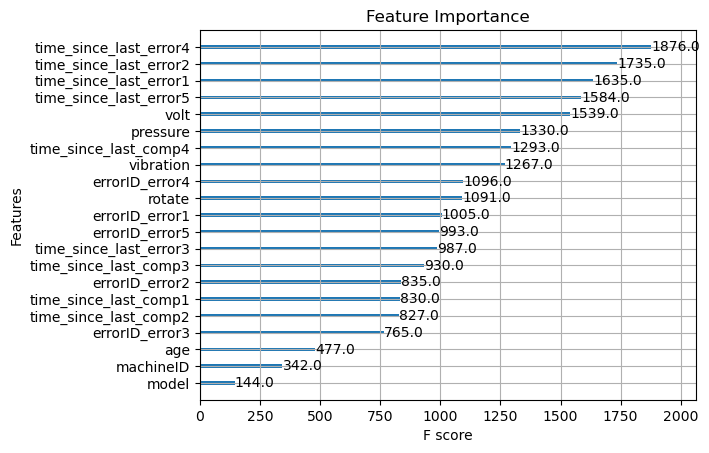

In [415]:
import matplotlib.pyplot as plt

# 特征重要性
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

epochs训练和验证误差

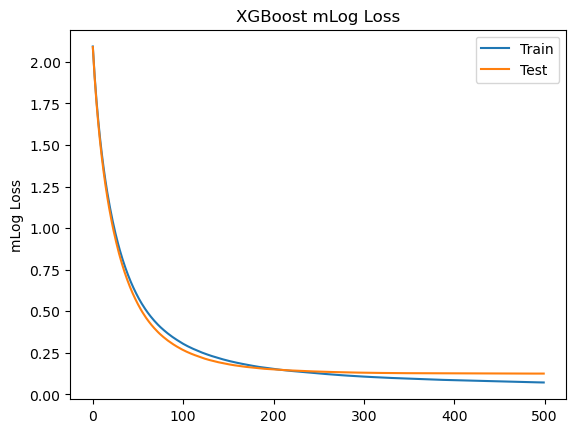

In [416]:
# 获取评估结果
evals_result = model.evals_result()

# 绘制训练和验证误差
epochs = len(evals_result['validation_0']['mlogloss'])
x_axis = range(0, epochs)
plt.plot(x_axis, evals_result['validation_0']['mlogloss'], label='Train')
plt.plot(x_axis, evals_result['validation_1']['mlogloss'], label='Test')
plt.legend()
plt.ylabel('mLog Loss')
plt.title('XGBoost mLog Loss')
plt.show()

宏平均与微平均分数

In [417]:
from sklearn.metrics import f1_score

# 假设 y_test 是真实标签，y_pred 是模型预测结果
y_pred = model.predict(X_test)

# 计算微平均和宏平均的F1分数
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')

print(f'Macro-average F1: {f1_macro:.2f}')
print(f'Micro-average F1: {f1_micro:.2f}')

Macro-average F1: 0.84
Micro-average F1: 0.95


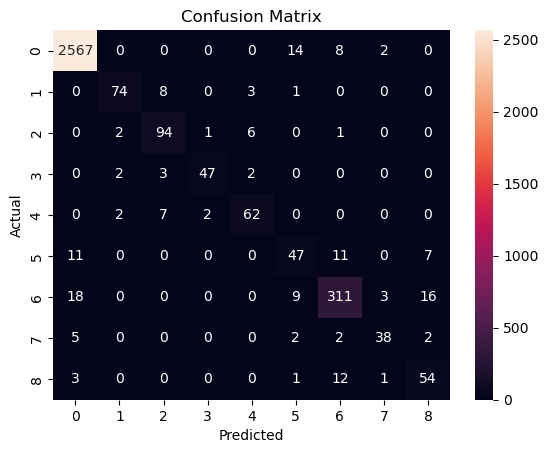

In [418]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 预测和真实标签（此处假设y_pred是模型预测结果，y_test是真实标签）
# y_pred = model.predict(X_test)

# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 绘制混淆矩阵
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Light Boost

In [383]:
import lightgbm as lgb
from sklearn.metrics import classification_report

# 转换数据格式
#train_data = lgb.Dataset(X_train_smote, label=y_train_smote)
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 设置参数
params = {
    'objective': 'multiclass',
    'num_class': num_class,  
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'max_depth': 3,
    'eta': 0.01,
    'n_estimators': 300,
    'bagging_fraction': 0.8,
    'bagging_freq': 3 
}

# 训练模型
modelLGB = lgb.train(params, train_data, valid_sets=[train_data, test_data])

D:\Anaconda3\envs\pytorch\lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3445
[LightGBM] [Info] Number of data points in the train set: 6056, number of used features: 21
[LightGBM] [Info] Start training from score -0.401592
[LightGBM] [Info] Start training from score -3.461781
[LightGBM] [Info] Start training from score -3.088404
[LightGBM] [Info] Start training from score -3.781551
[LightGBM] [Info] Start training from score -3.510308
[LightGBM] [Info] Start training from score -3.527021
[LightGBM] [Info] Start training from score -2.048230
[LightGBM] [Info] Start training from score -3.963873
[LightGBM] [Info] Start training from score -3.738991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

In [384]:
from sklearn.metrics import mean_absolute_error
# 预测
y_pred = modelLGB.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)  

# 评估
report = classification_report(y_test, y_pred)
print(report)

# 使用模型对测试集数据进行预测
# predictions = modelLGB.predict(X_test, num_iteration=modelLGB.best_iteration)
# predictions[:5]

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1715
           1       0.87      0.90      0.89        92
           2       0.92      0.84      0.88       107
           3       0.87      0.94      0.90        49
           4       0.84      0.87      0.86        71
           5       0.83      0.68      0.75        74
           6       0.93      0.94      0.93       358
           7       0.93      0.80      0.86        50
           8       0.91      0.76      0.83        80

    accuracy                           0.95      2596
   macro avg       0.90      0.86      0.88      2596
weighted avg       0.95      0.95      0.95      2596



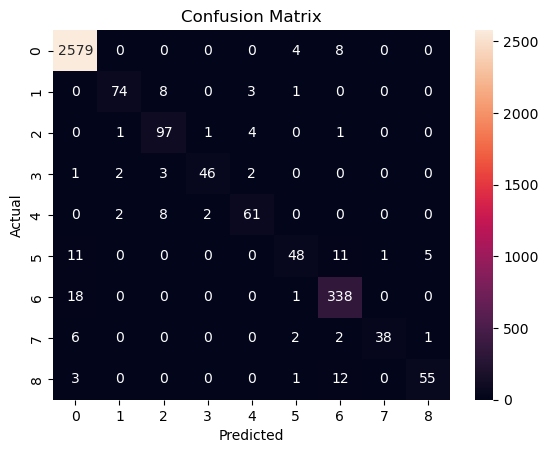

In [284]:
# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 绘制混淆矩阵
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()